<a href="https://colab.research.google.com/github/hiydavid/time_series_forecasting/blob/main/notebooks/time_series_forecasting_state_space_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with State Space Models

---

Perform time series forecasting with state spaces models, using libraries such as:
1. StatsModels

I will cover the follow models / algorithms:
1. Unobserved Componnes Model: [StatsModels](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
2. Gaussian Hidden Markov Model: [HMMLearn](https://hmmlearn.readthedocs.io/en/latest/) 

---
# Loab libraries

In [4]:
!pip install hmmlearn

     |████████████████████████████████| 378kB 5.3MB/s 


In [5]:
# load libraries
import warnings

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import hmmlearn
from hmmlearn.hmm import GaussianHMM

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

warnings.filterwarnings("ignore")
path = '/content/drive/MyDrive/Colab/projects/time_series_forecasting/data/'

In [6]:
# load global_temp data
gt = pd.read_csv(path + 'global_temps.csv')
gt.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [8]:
# load nile_river data
nile = pd.read_csv(path + 'nile_river.csv', index_col = 0)
nile.head()

,year,val
1,1871,1120
2,1872,1160
3,1873,963
4,1874,1210
5,1875,1160


---

# Model #1: Unobserved Component Model

## Preprocess data

In [11]:
# pivot
gt = gt.pivot(index='Date', columns='Source', values='Mean')
gt.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


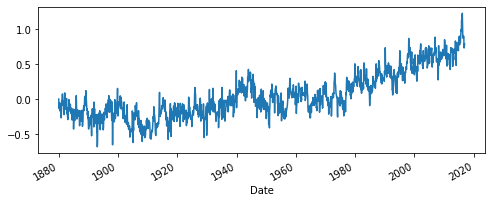

In [12]:
# set index to datetime
gt.index = pd.to_datetime(gt.index)
gt['GCAG'].plot()

## Exploratory data analysis

Pearson Corr: (0.837377527891214, 1.5894725243753573e-67)


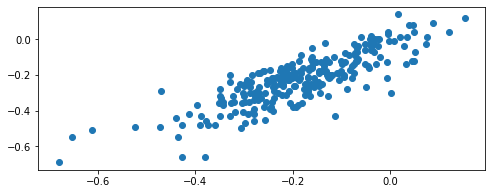

In [13]:
# correlations between measurements
print('Pearson Corr:', pearsonr(gt['1880':'1900'].GCAG, gt['1880':'1900'].GISTEMP))
plt.scatter(gt['1880':'1900'][['GCAG']], gt['1880':'1900'][['GISTEMP']])

Pearson Corr (0.1546405732961276, 0.01650223473095511)


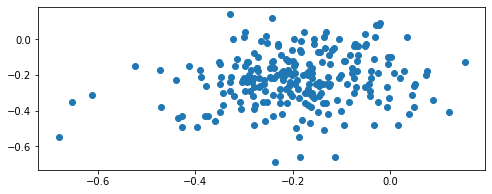

In [14]:
# correlations between measurements at a year-lag
plt.scatter(gt['1880':'1899'][['GCAG']], gt['1881':'1900'][['GISTEMP']])
print('Pearson Corr', pearsonr(gt['1880':'1899'].GCAG, gt['1881':'1900'].GISTEMP))

## Initial model

In [15]:
# set training data
train = gt['1960':]
train.head()

Source,GCAG,GISTEMP
Date,,
1960-01-06,0.0032,-0.01
1960-02-06,0.1858,0.14
1960-03-06,-0.2041,-0.36
1960-04-06,-0.0954,-0.16
1960-05-06,-0.0841,-0.08


In [16]:
# set model params
model = {
    'level': 'smooth trend', 
    'cycle': False, 
    'seasonal': None, 
}

In [17]:
# fit model
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

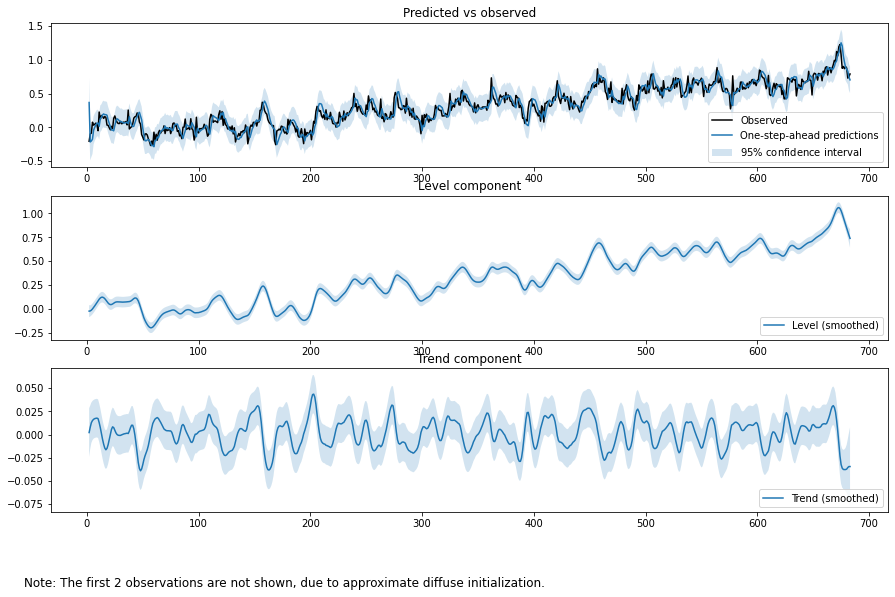

In [18]:
# plot components
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [19]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

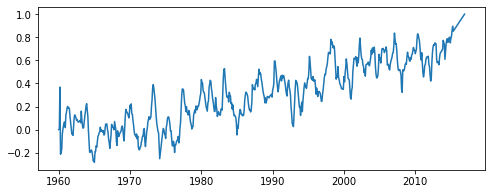

In [20]:
# plot prediction
plt.plot(predict)

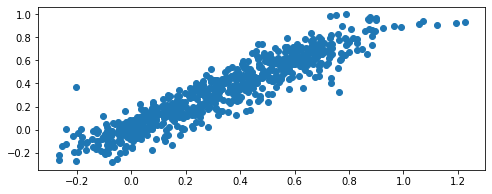

In [21]:
# prediction correlation with actuals
plt.scatter(train['GCAG'], predict)

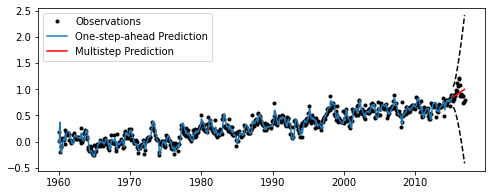

In [22]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

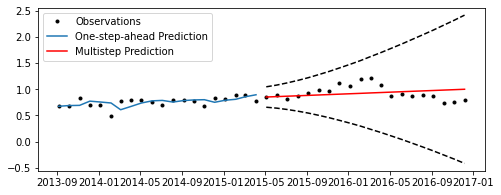

In [23]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

## Model with seasonality

In [24]:
# refit model
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

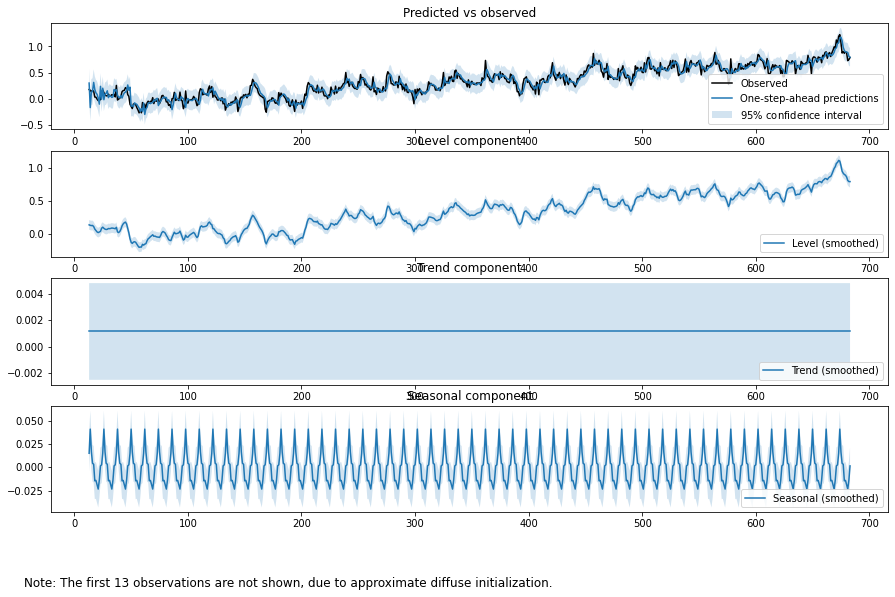

In [25]:
# plot components
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [26]:
print('Pearson Corr:', pearsonr(gcag_res.predict(), train['GCAG']))
print(np.mean(np.abs(gcag_res.predict() - train['GCAG'])))
print(np.mean(np.abs(res.predict() - train['GCAG'])))

Pearson Corr: (0.9376554633519587, 3.16460221e-315)
0.07721215185716089
0.07203380144744741


---
# Model #2: Gaussian Hidden Markov Model

## Fit model

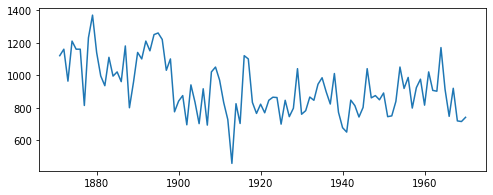

In [27]:
# plot nile
plt.plot(nile.year, nile.val)

In [28]:
# create model fit function
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)

    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]

    return (relabeled_states, mus, sigmas, transmat, model)

In [29]:
# model 3 hidden states
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 3)

[ 796.06732375 1097.27216026  884.87213564]
[ 67.19550566 133.0357056  138.81884828]


In [30]:
# function to plot hidden states
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year)')
    ax1.set_ylabel('Nile river flow',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

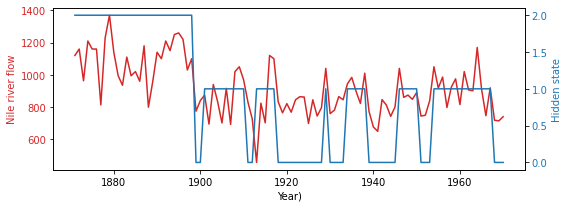

In [32]:
# plot hidden states
plot_states(nile.val, hidden_states, nile.year)

In [35]:
# view mean of each hidden states
np.set_printoptions(precision = 3, suppress = True)
mus

array([ 796.067,  884.872, 1097.272])

In [36]:
# view state-transition prob matrix
transmat

array([[0.508, 0.492, 0.   ],
       [0.305, 0.695, 0.   ],
       [0.036, 0.   , 0.964]])